# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Root hydraulics

1. Root water uptake from a static soil 

2. Root hydraulic conductance (Krs)  

3. Standard uptake fraction (SUF)


### 0. Loading libraries

In [3]:
# generic Python libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG, Image, display # to show svg files in the notebook

# specific CPlantBox libraries
search_path = '../lib'
sys.path.append(search_path)
import plantbox as pb #CPlantBox itself
import visualisation.vtk_plot as vp # for quick vizualisations

### Root water uptake from a static soil 
The plant structure can be coupled with inner plant water flow thanks to two new libraries, one for parameters storage and one containing the solver.

In [4]:
from functional.PlantHydraulicParameters import PlantHydraulicParameters  
from functional.PlantHydraulicModel import HydraulicModel_Doussan

Water flow in the root system is computed according to the xylem water potential gradients between nodes, driven by the boundary condition at the root collar. In other words, the root collar (top of the root system) acts as a hoover that sucks-in the water around the roots.\
At the root collar, either the water potential or the water flux can be prescribed (Dirichlet or Neumann boundary conditions). \
Root water uptake is computed as the sum of the radial fluxes into each root segment, according the the water potential differences between xylem and soil. \
In the example below, we set a constant and uniform total soil water potential, and constant root hydraulic properties. 

Root collar potential -1000 [cm], transpiration -18.3259 [cm3/day]
Root collar potential -681.972 [cm], transpiration -10 [cm3/day]


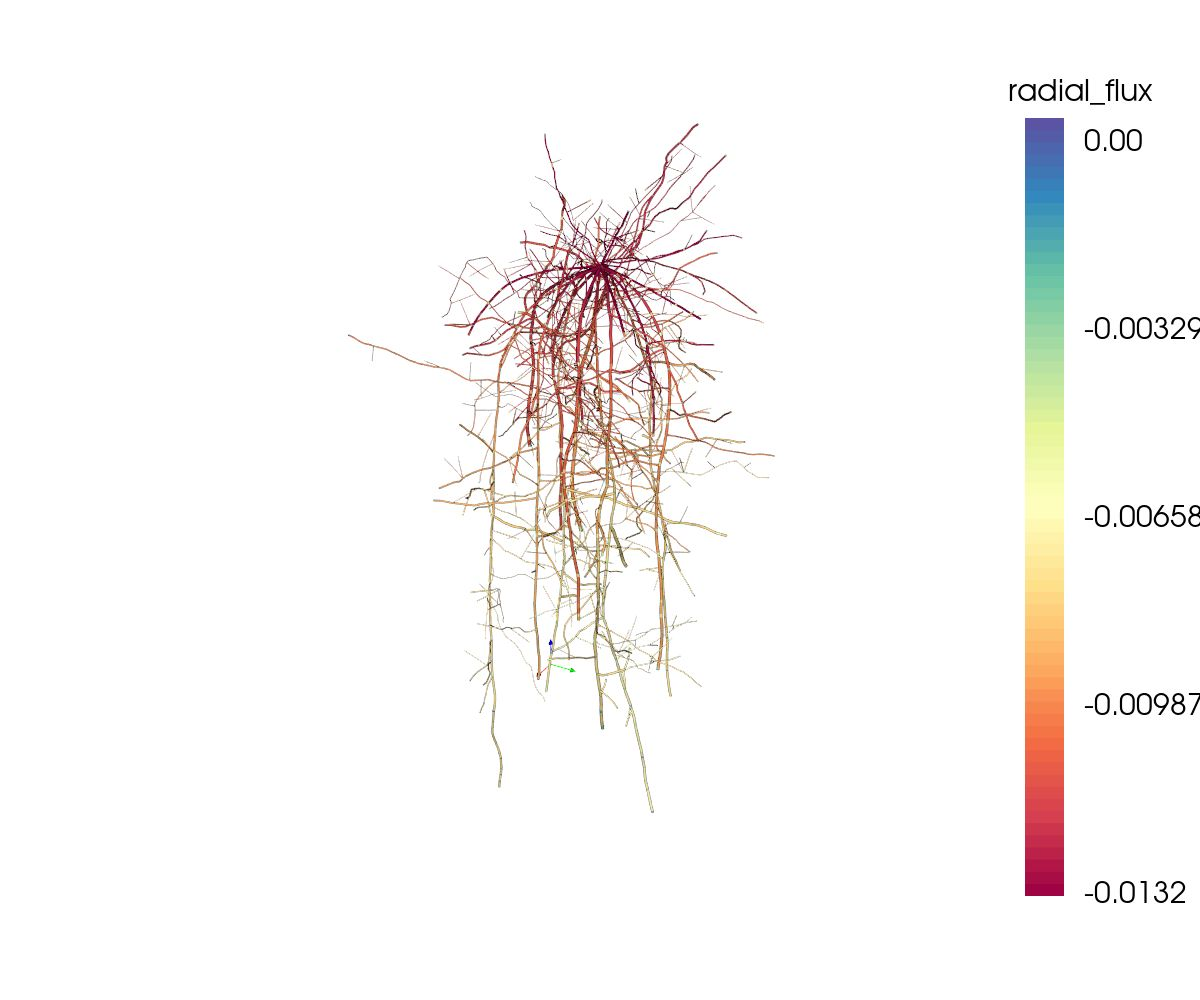

([<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x0000018AB8289B90) at 0x0000018AC78E2620>,
  <vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x0000018AB82887E0) at 0x0000018AC77CB400>],
 <vtkmodules.vtkRenderingAnnotation.vtkScalarBarActor(0x0000018AB4ED12D0) at 0x0000018AC7A642E0>)

In [9]:
""" Parameters """  # 
initial_age = 14  # root system age [day]
kx = 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]
Hs = -300  # soil total potential [cm]
h0 = -1000  # dirichlet bc at top [cm] 
t_pot = -10  # potential plant transpiration [cm3/day] 

""" root system """  
plant = pb.MappedPlant()  
path =  "../modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI"
plant.readParameters(path + name + ".xml")
plant.initialize()
plant.simulate(initial_age)  

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.set_kr_const(kr)
params.set_kx_const(kx)
hm = HydraulicModel_Doussan(plant, params)

""" Numerical solution """ 
ns = plant.getNumberOfMappedSegments()
hsr = plant.total2matric(Hs * np.ones((ns,)))  # define manually the water potential around the roots
hx = hm.solve_dirichlet(initial_age, h0, hsr, cells = False) 
print("Root collar potential {:g} [cm], transpiration {:g} [cm3/day]".format(hx[0], hm.get_transpiration(initial_age, hx, hsr)))
hx = hm.solve_neumann(initial_age, t_pot, hsr, cells = False)  
print("Root collar potential {:g} [cm], transpiration {:g} [cm3/day]".format(hx[0], hm.get_transpiration(initial_age, hx, hsr)))  # |\label{l41:numerical_end}|

""" Additional vtk plot """
ana = pb.SegmentAnalyser(hm.ms.mappedSegments())  
ana.addData("hx", hx)  # xylem potentials [cm]
ana.addFluxes(hm, hx, hsr, initial_age)  # "axial_flux" [cm3/day], "radial_flux" [ (cm3/cm2) / day] 
vp.plot_plant(ana, "radial_flux", interactiveImage = False)  


**Q: Why doe we obtain different results between the dirichlet and the Neuman boundary condition?**\
**Q: In the code above, where is the Neumann boundary condition defined?**\
**Q: Lower and increase the Dirichlet and Neumann boundary conditions. How are the results affected (root collar potential, actual transpiration)?**\
**Q: Change the plant age, kx, and kr. How do those parameters affect the plant transpiration rate? The water potential at the root collar? Why?**\
**Q: where in the root system do we have the highest water uptake? Is this result realistic?**

In the example below, we use the hm.solve function, which can use both a Dirichlet and a Neumann boundary condition. 
Look at the difference between potential and actual transpiration and at the water potential at the root collar. 

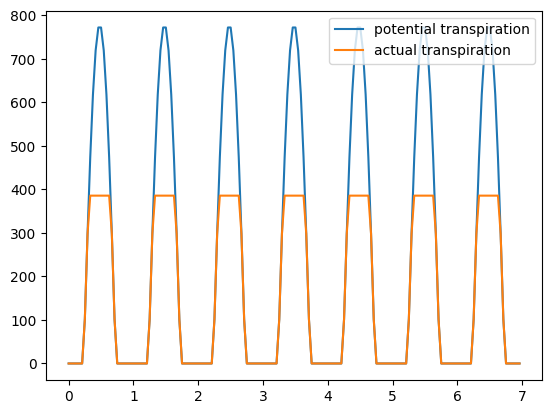

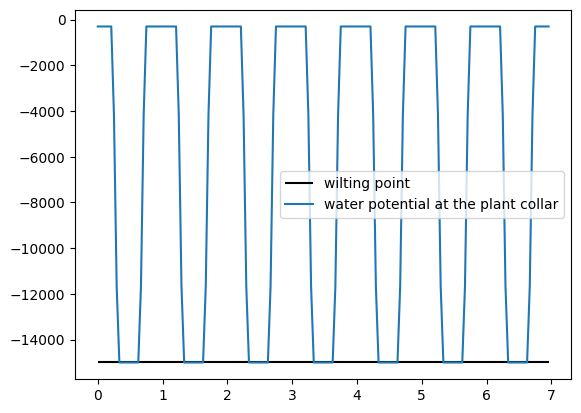

In [10]:
""" Parameters """  
sim_time = 7
dt = 3600./(24.*3600)
initial_age = 14  # root system age [day]
kx = 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]
Hs = -300  # soil total potential [cm]
t_pot = -250  # potential plant transpiration per day [cm3/day] 

def sinusoidal2(t, dt):
    """ sinusoidal function from 6:00 - 18:00, 0 otherwise (used for transpiration, integral over one day is 1)"""
    return np.maximum(0., np.pi * (np.cos(2 * np.pi * (t - 0.5)) + np.cos(2 * np.pi * ((t + dt) - 0.5))) / 2)

""" root system """  
plant = pb.MappedPlant()  
path = "../modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI"
plant.readParameters(path + name + ".xml")
plant.initialize(False)
plant.simulate(initial_age)  

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.set_kr_const(kr)
params.set_kx_const(kx)
hm = HydraulicModel_Doussan(plant, params)  

""" Simulation loop """ 
ns = plant.getNumberOfMappedSegments()
hsr = plant.total2matric(Hs * np.ones((ns,)))  # static uniform total potential defined manually

N = int(sim_time/dt)
h_collar_ = []
t_act_ = []
for i in range(0, N):
    t = i*dt # current simulation time 
    rx = hm.solve(initial_age, t_pot*sinusoidal2(t,dt), hsr, cells = False)  # uses both a Dirichlet and a Neumann boundary condition
    t_act = hm.get_transpiration(sim_time, rx, hsr, cells = False)
    t_act_.append(t_act)
    h_collar_.append(rx[hm.collar_index_])

t = np.linspace(0, (N-1)*dt, N)
plt.plot(t, -t_pot*sinusoidal2(t,dt), label = "potential transpiration")
plt.plot(t, -np.array(t_act_), label = "actual transpiration")
plt.legend()
plt.show()
plt.hlines(hm.wilting_point,xmin = t[0],xmax=t[-1], label = "wilting point",colors='k')
plt.plot(t, h_collar_, label = "water potential at the plant collar")
plt.legend()
plt.show()

**Q: In the code above, th epotential transpiration is sometimes lower than the potential transpiration. What does that mean?**\
**Q: In the simulated days, when is the transpiration set by the Neumann boundary condition? By the Dirichlet boundary condition?**\
**Q: Change the parameters so that the actual transpiration is always equal to the potential transpiration.**


The conductivities can be given as a constant for the whole root system (see previous examples), for each root subtype, for each segment, or according to the root age. In the example below, conductivity varies with the root age.
The graphic show the radial and axial conductivites according to the age of the root segment.
**Q: in the code below change the value of the input parameters to make the radial conductances reach their final (lowest) values at day 20.**\
**Q: in the code below change the value of the input parameters to make the axial conductances reach their final (highest) values at day 20.**

0.357
0.00411

SubType 0 for negative age: kx = 0.0001, kr = 0.0001
SubType 0 for old root age: kx = 0.0001, kr = 0.0001
SubType 1 for negative age: kx = 0.0674, kr = 0.00114
SubType 1 for old root age: kx = 0.357, kr = 0.000517
SubType 2 for negative age: kx = 0.000407, kr = 0.00411
SubType 2 for old root age: kx = 0.0136, kr = 0.00158
SubType 3 for negative age: kx = 0.000407, kr = 0.00411
SubType 3 for old root age: kx = 0.0136, kr = 0.00158
SubType 4 for negative age: kx = 0.0674, kr = 0.00114
SubType 4 for old root age: kx = 0.357, kr = 0.000517



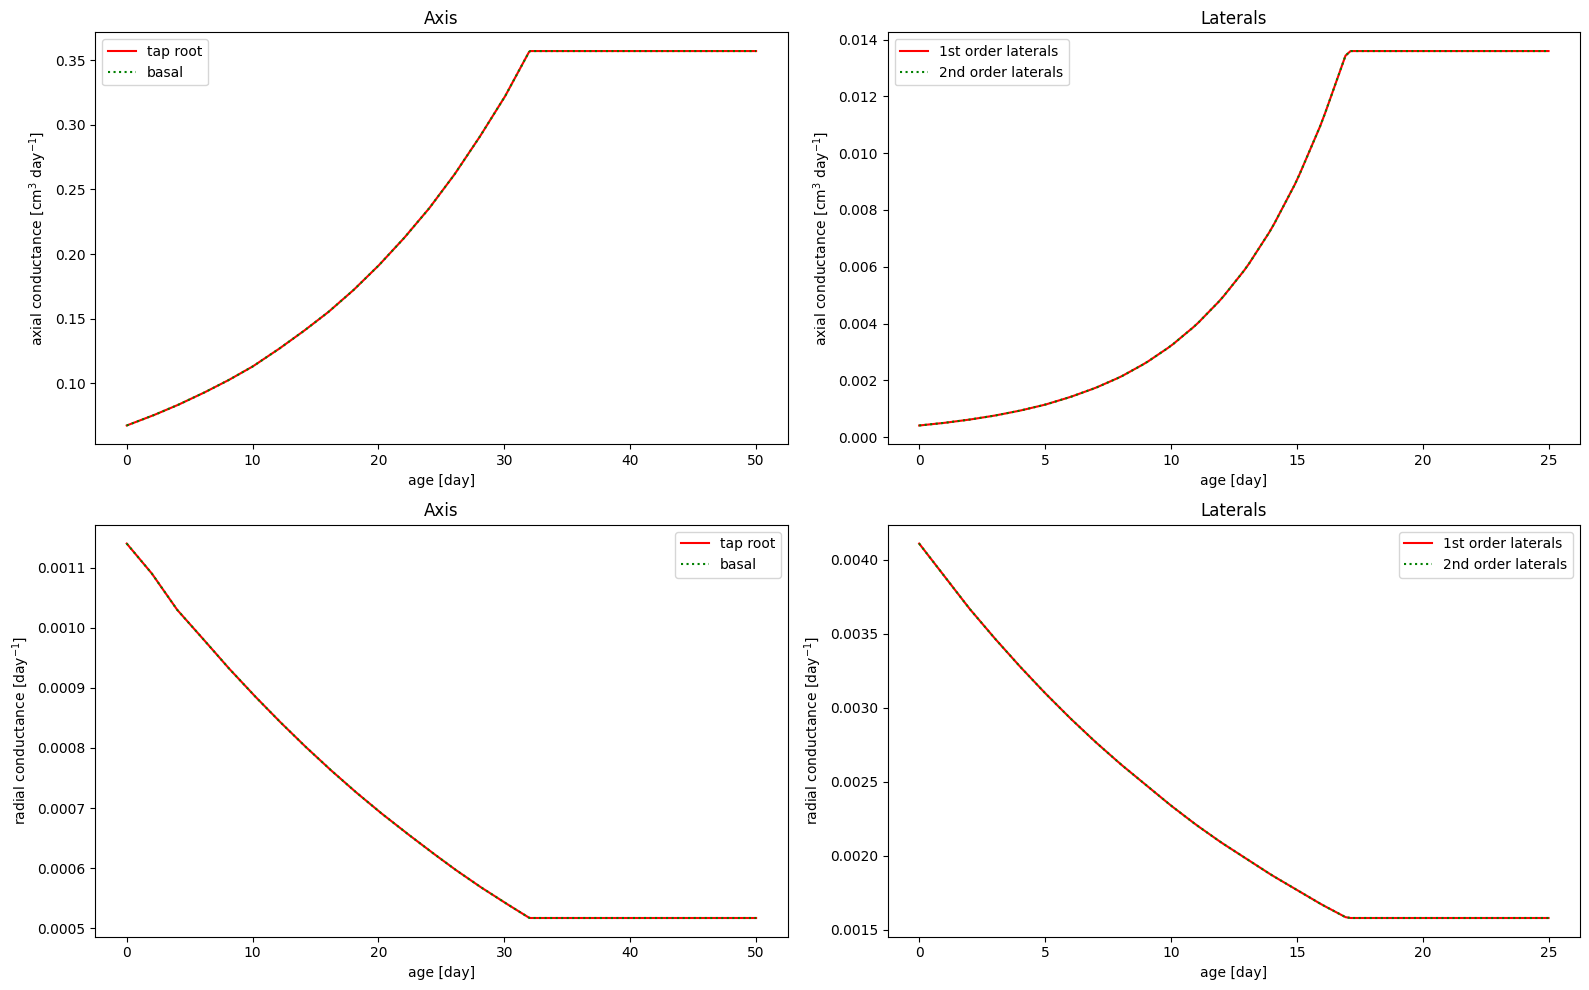

In [5]:
param = PlantHydraulicParameters()
param = PlantHydraulicParameters()

# ---- kr ----
kr0_age = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32])
kr0_values = np.array([1.14e-03, 1.09e-03, 1.03e-03, 9.83e-04, 9.35e-04,
                       8.90e-04, 8.47e-04, 8.06e-04, 7.67e-04, 7.30e-04,
                       6.95e-04, 6.62e-04, 6.30e-04, 5.99e-04, 5.70e-04,
                       5.43e-04, 5.17e-04])

kr1_age = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                    14, 15, 16, 17])
kr1_values = np.array([4.11e-03, 3.89e-03, 3.67e-03, 3.47e-03, 3.28e-03,
                       3.10e-03, 2.93e-03, 2.77e-03, 2.62e-03, 2.48e-03,
                       2.34e-03, 2.21e-03, 2.09e-03, 1.98e-03, 1.87e-03,
                       1.77e-03, 1.67e-03, 1.58e-03])

param.set_kr_age_dependent(kr0_age, kr0_values, subType=[1, 4])
param.set_kr_age_dependent(kr1_age, kr1_values, subType=[2, 3])


# ---- kx ----
kx0_age = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
                    26, 28, 30, 32])
kx0_values = np.array([6.74e-02, 7.48e-02, 8.30e-02, 9.21e-02, 1.02e-01,
                       1.13e-01, 1.26e-01, 1.40e-01, 1.55e-01, 1.72e-01,
                       1.91e-01, 2.12e-01, 2.35e-01, 2.61e-01, 2.90e-01,
                       3.21e-01, 3.57e-01])

kx1_age = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                    14, 15, 16, 17])
kx1_values = np.array([4.07e-04, 5.00e-04, 6.15e-04, 7.56e-04, 9.30e-04,
                       1.14e-03, 1.41e-03, 1.73e-03, 2.12e-03, 2.61e-03,
                       3.21e-03, 3.95e-03, 4.86e-03, 5.97e-03, 7.34e-03,
                       9.03e-03, 1.11e-02, 1.36e-02])

param.set_kx_age_dependent(kx0_age, kx0_values, subType=[1, 4])
param.set_kx_age_dependent(kx1_age, kx1_values, subType=[2, 3])

_ = param.plot_conductivities(axes_ind=[1, 4], lateral_ind=[2, 3])

### Root hydraulic conductance (Krs) 

The code below computes the root system conductance (Krs) for different root architectures over time.

**Q: define in you own word the  root system conductance**\
**Q: Looking at the outputs below, Do you see a link between total root system length and final Krs? Between total surface of the root system and final Krs? Can you explain why?**


Simulating: Heliantus_Pagès_2013

Simulating: Glycine_max_Moraes2020_opt2

Simulating: Brassica_oleracea_Vansteenkiste_2014

Simulating: Zea_mays_1_Leitner_2010


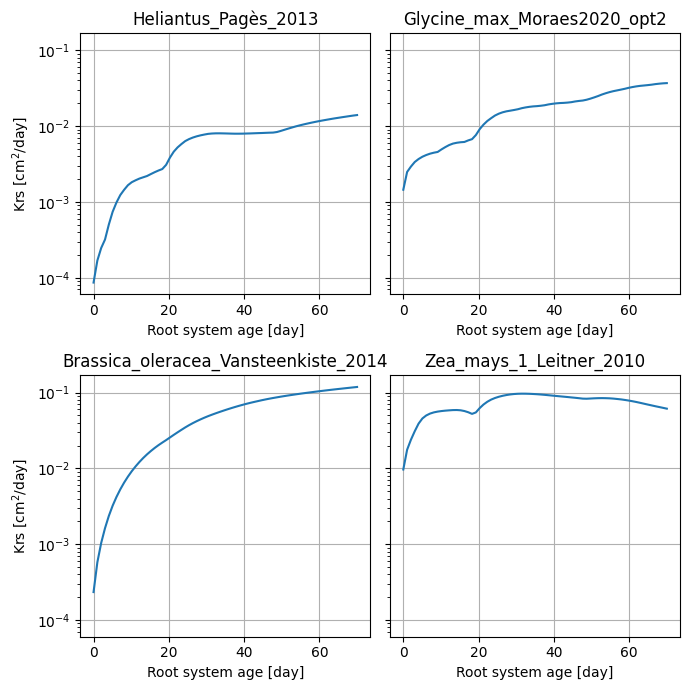


Summary:
Heliantus_Pagès_2013 | Total root length: 15819.25 cm | Surface area:  1073.08 cm2
Glycine_max_Moraes2020_opt2 | Total root length:  8587.32 cm | Surface area:  1670.37 cm2
Brassica_oleracea_Vansteenkiste_2014 | Total root length: 27573.36 cm | Surface area:  2391.13 cm2
Zea_mays_1_Leitner_2010 | Total root length: 10507.19 cm | Surface area:  1982.58 cm2


In [15]:
sim_time = 70  
dt = 1

architectures = [  
    "Heliantus_Pagès_2013",
    "Glycine_max_Moraes2020_opt2",
    "Brassica_oleracea_Vansteenkiste_2014",
    "Zea_mays_1_Leitner_2010"
]

path = sourcedir + "modelparameter/structural/rootsystem/"  

""" Root hydraulic properties """  
param = PlantHydraulicParameters()
# ---- kr ----
kr0_age = np.array([0., 12.5, 20.9, 44.6, 62.7, 100.])
kr0_values = np.array([2.2e-4, 2.2e-4, 8.0e-5, 8.0e-5, 1.9e-5, 1.9e-5])

kr1_age = np.array([0., 10., 15., 25.])
kr1_values = np.array([1.8e-4, 1.8e-4, 1.7e-5, 1.7e-5])

param.set_kr_age_dependent(kr0_age, kr0_values, subType=[1, 4])
param.set_kr_age_dependent(kr1_age, kr1_values, subType=[2, 3])


# ---- kx ----
kx0_age = np.array([0., 18.3, 21., 47., 61., 100.])
kx0_values = np.array([2.7e-2, 2.7e-2, 3.3e-1, 3.3e-1, 4.2, 4.2])

kx1_age = np.array([0., 9., 13., 20., 25.])
kx1_values = np.array([1.e-4, 2.e-4, 6.e-4, 1.73e-3, 1.73e-3])

param.set_kx_age_dependent(kx0_age, kx0_values, subType=[1, 4])
param.set_kx_age_dependent(kx1_age, kx1_values, subType=[2, 3])

""" Simulation loop""" 
krs_all, lengths, surfaces  = [], [], []

for name in architectures:
    print(f"\nSimulating: {name}")

    plant = pb.MappedPlant()  
    plant.readParameters(path + name + ".xml")
    plant.initialize(False)

    hm = HydraulicModel_Meunier(plant, param) 
    krs_values = []
    arch_lengths = []
    arch_surfaces = []
    N = int(sim_time/dt)
    for i in range(0, N):
        plant.simulate(dt)    
        krs, _ = hm.get_krs(i*dt)
        krs_values.append(krs)  
        total_length = np.sum(np.array(plant.getParameter("length")))
        total_surface = np.sum(np.array(plant.getParameter("surface")))
        arch_lengths.append(total_length)
        arch_surfaces.append(total_surface)        

    krs_all.append(krs_values)
    lengths.append(arch_lengths[-1])  # final length
    surfaces.append(arch_surfaces[-1])  # final surface 

""" Plot """  
fig, axes = plt.subplots(2, 2, figsize = (7,7), sharey = True)
for i, ax in enumerate(axes.flat):
    ax.plot(np.linspace(0, sim_time,N), krs_all[i])
    ax.set_title(architectures[i])
    ax.set_xlabel("Root system age [day]")
    ax.set_yscale("log")
    if i%2 == 0:
        ax.set_ylabel("Krs [cm$^2$/day]")
    ax.grid(True)
plt.tight_layout()
plt.show()  

print("\nSummary:")
for i, name in enumerate(architectures):
    print(f"{name:20s} | Total root length: {lengths[i]:8.2f} cm | Surface area: {surfaces[i]:8.2f} cm2")

In [82]:
sim_time = 70  
name = "Zea_mays_1_Leitner_2010"
path = sourcedir + "modelparameter/structural/rootsystem/"  

""" Root hydraulic properties """  
param = PlantHydraulicParameters()

kr0 = np.array([[0., 2.2e-4], [12.5, 2.2e-4], [20.9, 8.0e-5], [44.6, 8.0e-5], [62.7, 1.9e-5], [100, 1.9e-5]])
kr1 = np.array([[0., 1.8e-4], [10, 1.8e-4], [15, 1.7e-5], [25, 1.7e-5]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1, 4])  
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 2.7e-2], [18.3, 2.7e-2], [21, 3.3e-1], [47, 3.3e-1], [61, 4.2], [100, 4.2]])
kx1 = np.array([[0, 1.e-4], [9, 2.e-4], [13, 6.e-4], [20, 1.73e-3], [25, 1.73e-3]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1, 4])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3]) 


plant = pb.MappedPlant(1)  
plant.readParameters(path + name + ".xml")
plant.initialize(False)

hm = HydraulicModel_Meunier(plant, param) 
plant.simulate(sim_time) 
krs, _ = hm.get_krs( sim_time)
print("Krs [cm2/day]:",krs) 


hs_total = -200.
hsx_total = np.ones((hm.ms.getNumberOfMappedSegments(), 1)) * (hs_total)
suf = hm.get_suf(sim_time)
heff = suf.dot(hsx_total)[0]
hx = hm.solve_dirichlet(sim_time, -15000, hm.ms.total2matric(hsx_total), cells = False)
t_act = -hm.get_transpiration(sim_time, hx, hm.ms.total2matric(hsx_total), cells = False)
hx_collar = hx[hm.collar_index()]
# Krs = ??

Krs [cm2/day]: 0.10176408690908884


/tmp/ipykernel_447645/941924748.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hx = hm.solve_dirichlet(sim_time, -15000, hm.ms.total2matric(hsx_total), cells = False)
/tmp/ipykernel_447645/941924748.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_act = -hm.get_transpiration(sim_time, hx, hm.ms.total2matric(hsx_total), cells = False)


### Standard uptake fraction (SUF)
The code below computes for each plant the standard uptake fraction. \
**Q: defines in you own word the standard uptake fraction**\
**Q: Looking at the outputs below, which root system can profit the most quickly from rainfall water?**


Simulating: Heliantus_Pagès_2013
MappedPlant::initializeLB 
Seed::initialize: RootSystem 

Simulating: Glycine_max_Moraes2020_opt2
MappedPlant::initializeLB 
Seed::initialize: RootSystem 

Simulating: Brassica_oleracea_Vansteenkiste_2014
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead

Simulating: Zea_mays_1_Leitner_2010
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


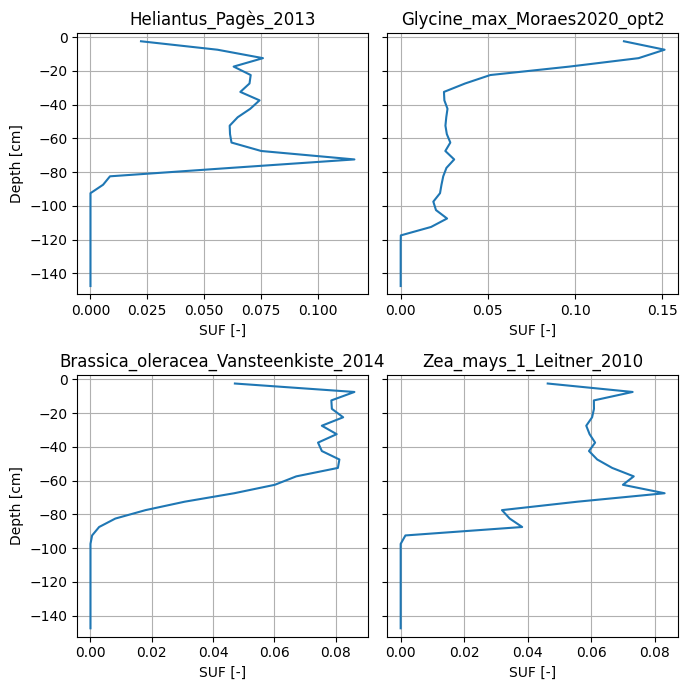

In [7]:
""" Simulation loop""" 
suf_profiles = [] # To store SUF depth profiles for all architectures at final sim_time

for name in architectures:
    print(f"\nSimulating: {name}")

    plant = pb.MappedPlant()  
    plant.readParameters(path + name + ".xml")
    plant.initialize()    
    hm = HydraulicModel_Meunier(plant, param)  # param from example before
    plant.simulate(sim_time)

    suf = hm.get_suf(sim_time)  
    ana = pb.SegmentAnalyser(plant)
    ana.addData("SUF", suf)  # suf at each segment in the 3d space

    bin_size = 5  # soil layer thickness is defined, for plotting purposes
    z_max = 0
    z_min = -150
    n_bins = int((z_max - z_min) / bin_size)
    suf_dist = ana.distribution("SUF", z_max, z_min, n_bins, True)  

    depths = np.linspace(z_max - bin_size / 2, z_min + bin_size / 2, n_bins)  
    suf_array = np.array(suf_dist)
    depth_array = np.array(depths)
    
    suf_profiles.append((suf_array, depth_array)) # for plotting

""" Plotting """
fig_suf, axes_suf = plt.subplots(2, 2, figsize = (7,7), sharey = True)  

for i, ax in enumerate(axes_suf.flat):
    suf, depth = suf_profiles[i]
    ax.plot(suf, depth)
    ax.set_xlabel("SUF [-]")
    if i % 2 == 0:
        ax.set_ylabel("Depth [cm]")
    ax.grid(True)
    ax.set_title(architectures[i])
    if len(depth) > 0:
        ax.set_ylim(depth.min() - 5, depth.max() + 5)  # optional padding

plt.tight_layout()
plt.show()  

**Q: Look at the code below. The last section of the code is commented out. Uncomment the code and using the radial_fluxes array recompute the suf array called 'suf_3d'**

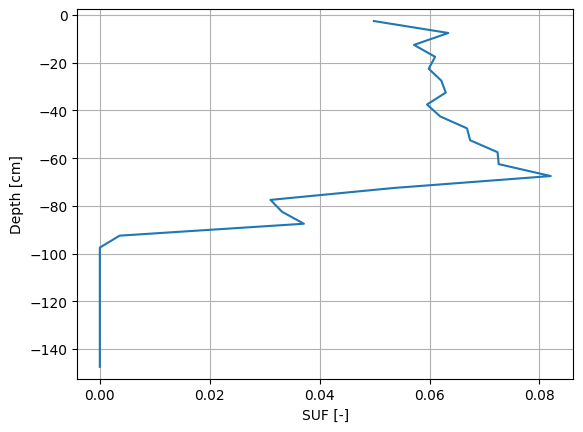

/tmp/ipykernel_447645/3819655464.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rsx = hm.ms.total2matric(rsx)


'\nsuf_3d = ?\nsuf_array, depth_array = get_1d_from_3d_suf(hm, suf_3d)\nplt.plot(suf_array, depth_array)\nplt.xlabel("SUF [-]")\nplt.ylabel("Depth [cm]")\nplt.grid(True)\nplt.ylim(depth_array.min() - 5, depth_array.max() + 5)  # optional padding\nplt.show()  \n'

In [83]:
sim_time = 70  
name = "Zea_mays_1_Leitner_2010"
path = sourcedir + "modelparameter/structural/rootsystem/"  

""" Root hydraulic properties """  
param = PlantHydraulicParameters()

kr0 = np.array([[0., 2.2e-4], [12.5, 2.2e-4], [20.9, 8.0e-5], [44.6, 8.0e-5], [62.7, 1.9e-5], [100, 1.9e-5]])
kr1 = np.array([[0., 1.8e-4], [10, 1.8e-4], [15, 1.7e-5], [25, 1.7e-5]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1, 4])  
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 2.7e-2], [18.3, 2.7e-2], [21, 3.3e-1], [47, 3.3e-1], [61, 4.2], [100, 4.2]])
kx1 = np.array([[0, 1.e-4], [9, 2.e-4], [13, 6.e-4], [20, 1.73e-3], [25, 1.73e-3]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1, 4])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3]) 


plant = pb.MappedPlant(1)  
plant.readParameters(path + name + ".xml")
plant.initialize(False)

hm = HydraulicModel_Meunier(plant, param) 
plant.simulate(sim_time) 


def get_1d_from_3d_suf(hm, suf):    
    ana = pb.SegmentAnalyser(hm.ms)
    ana.addData("SUF", suf)  # suf at each segment in the 3d space
    
    bin_size = 5  # soil layer thickness is defined, for plotting purposes
    z_max = 0
    z_min = -150
    n_bins = int((z_max - z_min) / bin_size)
    suf_dist = ana.distribution("SUF", z_max, z_min, n_bins, True)  
    
    depths = np.linspace(z_max - bin_size / 2, z_min + bin_size / 2, n_bins)  
    suf_array = np.array(suf_dist)
    depth_array = np.array(depths)
    return suf_array, depth_array


def get_variables_for_suf(hm, time):
    n = hm.ms.getNumberOfMappedSegments()
    rsx = np.ones((n, 1)) * (-500)
    rsx = hm.ms.total2matric(rsx)
    rx = hm.solve_dirichlet(sim_time, -15000, rsx, cells = False)
    q = hm.radial_fluxes(sim_time, rx, rsx)
    return np.array(q)
    
suf_3d = hm.get_suf(sim_time)
suf_array, depth_array = get_1d_from_3d_suf(hm, suf_3d)

plt.plot(suf_array, depth_array)
plt.xlabel("SUF [-]")
plt.ylabel("Depth [cm]")
plt.grid(True)
plt.ylim(depth_array.min() - 5, depth_array.max() + 5)  # optional padding
plt.show()  

radial_fluxes = get_variables_for_suf(hm, sim_time)
'''
suf_3d = ?
suf_array, depth_array = get_1d_from_3d_suf(hm, suf_3d)
plt.plot(suf_array, depth_array)
plt.xlabel("SUF [-]")
plt.ylabel("Depth [cm]")
plt.grid(True)
plt.ylim(depth_array.min() - 5, depth_array.max() + 5)  # optional padding
plt.show()  
'''